# Siamese on receptors

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import glob
import numpy as np
import editdistance
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
from math import ceil
import gzip
import pandas as pd
import time
import math
from sklearn.metrics.pairwise import pairwise_distances
import gzip
import pickle
import re
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
import os

print(plt.style.available)
plt.style.use('seaborn-whitegrid')

ImportError: No module named 'editdistance'

In [282]:
print(np.load("Gen_test_levenshtein.npz").files)
np.load("Gen_test_levenshtein.npz")["dist10"]

['dist10', 'inds10', 'inds5', 'dist5', 'inds20', 'dist20']


array([ 21.,  28.,  28., ...,  42.,  50.,  47.])

In [287]:
def load_embeds(filename):
    nparr = np.load(filename)
    return nparr["seq"], nparr["emb"]

def embed_dist(emb_vec, mat_file, K):
    old_dist = np.load(mat_file)["dist" + str(K)] / K
    inds_vec = np.load(mat_file)["inds" + str(K)]
    
    res = []
    for i in range(old_dist.shape[0]):
        res.append((pairwise_distances(emb_vec[i].reshape((1, -1)), emb_vec[inds_vec[i]], metric="euclidean")).mean())
    new_dist = np.array(res)

    corS = spearmanr(new_dist, old_dist)
    corP = pearsonr(new_dist, old_dist)
    corK = kendalltau(new_dist, old_dist)
    
    return new_dist, old_dist, corS, corP, corK

In [84]:
def plot_seq_corr(filepath, ax, i, j):        
    seq_vec, emb_vec = load_embeds(filepath)
    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 10)
    tmp2 = round(tmp[2][0], 2), round(tmp[3][0], 2), round(tmp[4][0], 2)
    
    ax[i][j].scatter(tmp[0], tmp[1], s=2)
    ax[i][j+1].scatter(rankdata(tmp[0]), rankdata(tmp[1]), s=2)
    
    ax[i][j].set_title("K=10; P=" + str(tmp2[0]))
    ax[i][j+1].set_title("K=10; K=" + str(tmp2[2]))
    
    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 20)
    tmp2 = round(tmp[2][0], 2), round(tmp[3][0], 2), round(tmp[4][0], 2)
    
    ax[i+1][j].scatter(tmp[0], tmp[1], s=2)
    ax[i+1][j+1].scatter(rankdata(tmp[0]), rankdata(tmp[1]), s=2)
    
    ax[i+1][j].set_title("K=20; P=" + str(tmp2[0]))
    ax[i+1][j+1].set_title("k=20; K=" + str(tmp2[2]))

In [257]:
def plot_tsne_corr(filepath, ax, i, j):        
    seq_vec, emb_vec = load_embeds(filepath)
    
    key = filepath.split("/")[-2]
    emb_vec = tsne_dict[key][0]
    
    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 10)
    tmp2 = round(tmp[2][0], 2), round(tmp[3][0], 2), round(tmp[4][0], 2)
    
    ax[i][j].scatter(tmp[0], tmp[1], s=2)
    ax[i][j+1].scatter(rankdata(tmp[0]), rankdata(tmp[1]), s=2)
    
    ax[i][j].set_title("K=10; P=" + str(tmp2[0]))
    ax[i][j+1].set_title("K=10; K=" + str(tmp2[2]))
    
    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 20)
    tmp2 = round(tmp[2][0], 2), round(tmp[3][0], 2), round(tmp[4][0], 2)
    
    ax[i+1][j].scatter(tmp[0], tmp[1], s=2)
    ax[i+1][j+1].scatter(rankdata(tmp[0]), rankdata(tmp[1]), s=2)
    
    ax[i+1][j].set_title("K=20; P=" + str(tmp2[0]))
    ax[i+1][j+1].set_title("K=20; K=" + str(tmp2[2]))

In [220]:
def plot_seq_rank(filepaths, target):
    assert(target in filepaths)
    target = target.split("/")[-1]
    
    res = {}
    for filepath in filepaths:
        seq_vec, emb_vec = load_embeds(filepath + "/embeddings.npz")
        
        key = filepath.split("/")[-1]
        print(key)
        
        tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 10)
        values_10 = np.array((round(tmp[2][0], 2), round(tmp[4][0], 2)))
    
        tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 20)
        values_20 = np.array((round(tmp[2][0], 2), round(tmp[4][0], 2)))
        
        res[key] = values_10, values_20
        
    perc_key = {}
    for key in res:
        if key != target:
            perc_key[key] = (res[target][0] / res[key][0] - 1) * 100, (res[target][1] / res[key][1] - 1) * 100
            
    return perc_key

In [308]:
def plot_clusters(res, labels, ax, legend=False, psize=4, alpha=1):
    labels = np.array(labels)

    for uniq_len in set(labels):
        ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize, alpha=alpha)

    colormap = plt.cm.RdBu #gist_ncar, nipy_spectral, Set1, Paired  
    colorst = [colormap(i) for i in np.linspace(-.8, 1.7, len(ax.collections))]

    for t, j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])

    if legend:
        ax.legend()
    

def plot_tsne(key, ax, psize=3, alpha=.5, legend=False):
    tsne_vec, lens_vec = tsne_dict[key]
    plot_clusters(tsne_vec, lens_vec, ax, legend, psize=psize, alpha=alpha)
    ax.set_title(key + " | " + "perp. 30")

In [111]:
tsne_dict = {}
for filepath in glob.glob("../disser_plots/experiment_3_2/inference/*"):
    key = filepath.split("/")[-1]
    print(key)
    seq_vec, emb_vec = load_embeds(filepath + "/embeddings.npz")
    tsne_dict[key] = (TSNE(perplexity=30, n_jobs=-1).fit_transform(emb_vec), [len(x) for x in seq_vec])

siam_inference_ae_lat30_hid32_l1_lev
siam_inference_ae_lat30_hid32_l1_loglev
siam_inference_ae_lat30_hid32_mse_lev
siam_inference_ae_lat30_hid32_mse_loglev
siam_inference_classic_siam
siam_inference_vae_lat30_hid32_l1_lev
siam_inference_vae_lat30_hid32_l1_loglev
siam_inference_vae_lat30_hid32_mse_lev
siam_inference_vae_lat30_hid32_mse_loglev
simple_ae


In [294]:
# with open("experiment_3_2/tsne_inference_perp30.pkl", "wb") as file:
#     pickle.dump(tsne_dict, file)

# Classic AE, simple Siamese

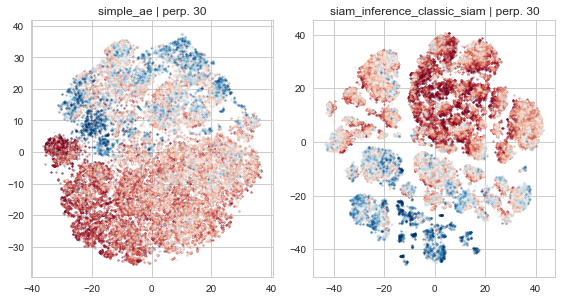

In [312]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(4)

plot_tsne("simple_ae", ax[0])
plot_tsne("siam_inference_classic_siam", ax[1])

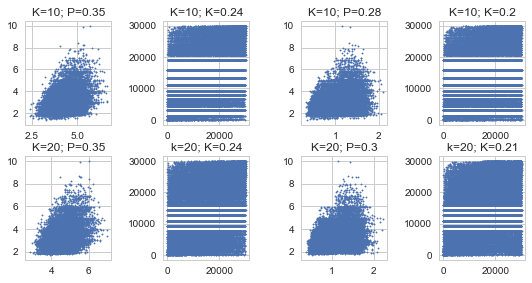

In [290]:
fig, ax = plt.subplots(2,4)
fig.tight_layout(pad=2)
fig.set_figwidth(8)
fig.set_figheight(4)

plot_seq_corr("../disser_plots/experiment_3_2/inference/simple_ae/embeddings.npz", ax, 0, 0)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_classic_siam/embeddings.npz", ax, 0, 2)

# Locality-sensitive Siamese VAE

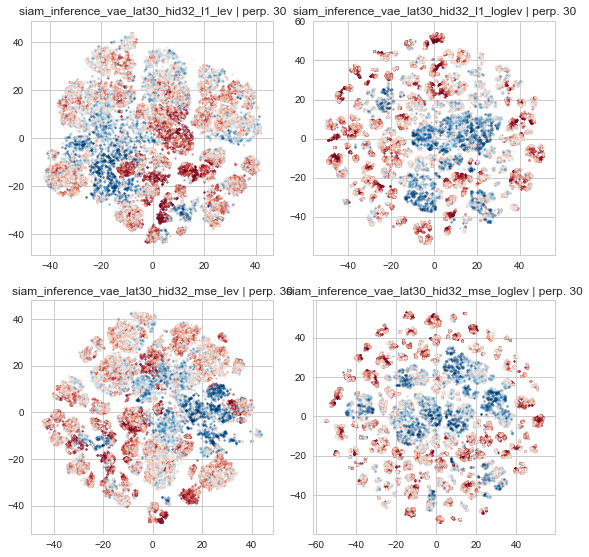

In [310]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(8)

plot_tsne("siam_inference_vae_lat30_hid32_l1_lev", ax[0][0])
plot_tsne("siam_inference_vae_lat30_hid32_l1_loglev", ax[0][1])
plot_tsne("siam_inference_vae_lat30_hid32_mse_lev", ax[1][0])
plot_tsne("siam_inference_vae_lat30_hid32_mse_loglev", ax[1][1])

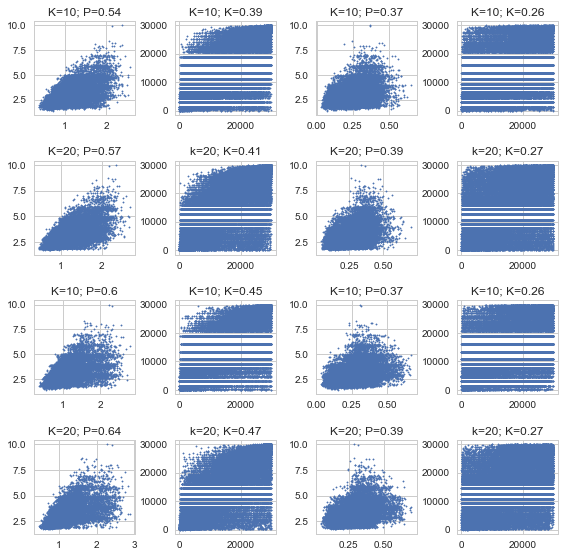

In [291]:
fig, ax = plt.subplots(4, 4)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(8)

plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_vae_lat30_hid32_l1_lev/embeddings.npz", ax, 0, 0)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_vae_lat30_hid32_l1_loglev/embeddings.npz", ax, 0, 2)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_vae_lat30_hid32_mse_lev/embeddings.npz", ax, 2, 0)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_vae_lat30_hid32_mse_loglev/embeddings.npz", ax, 2, 2)

# Locality-sensitive Siamese, AE

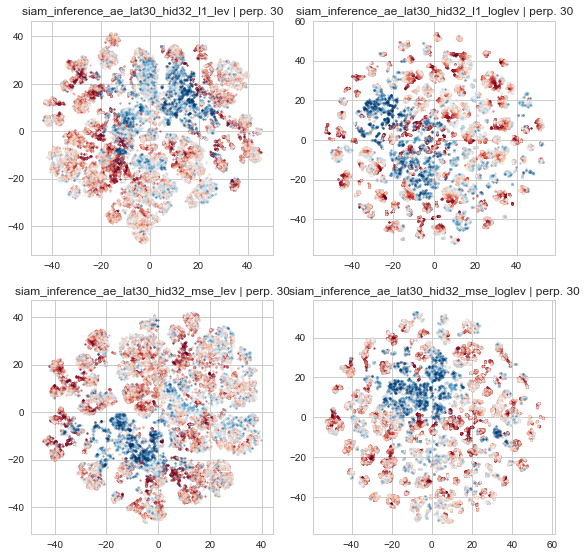

In [210]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(8)

plot_tsne("siam_inference_ae_lat30_hid32_l1_lev", ax[0][0])
plot_tsne("siam_inference_ae_lat30_hid32_l1_loglev", ax[0][1])
plot_tsne("siam_inference_ae_lat30_hid32_mse_lev", ax[1][0])
plot_tsne("siam_inference_ae_lat30_hid32_mse_loglev", ax[1][1])

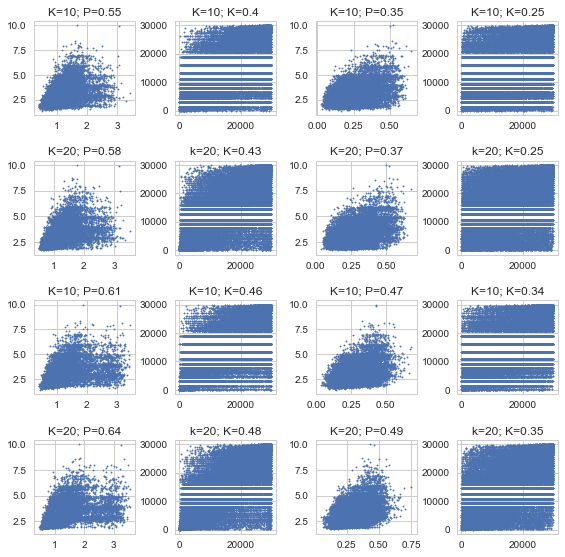

In [219]:
fig, ax = plt.subplots(4, 4)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(8)

plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_l1_lev/embeddings.npz", ax, 0, 0)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_l1_loglev/embeddings.npz", ax, 0, 2)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_lev/embeddings.npz", ax, 2, 0)
plot_seq_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_loglev/embeddings.npz", ax, 2, 2)

# Final plots

In [ ]:
perc_dict = plot_seq_rank(glob.glob("../disser_plots/experiment_3_2/inference/*"), 
              "../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_loglev")

In [231]:
perc_dict

{'siam_inference_ae_lat30_hid32_l1_lev': (array([-14.54545455, -15.        ]),
  array([-15.51724138, -18.60465116])),
 'siam_inference_ae_lat30_hid32_l1_loglev': (array([ 34.28571429,  36.        ]),
  array([ 32.43243243,  40.        ])),
 'siam_inference_ae_lat30_hid32_mse_lev': (array([-22.95081967, -26.08695652]),
  array([-23.4375    , -27.08333333])),
 'siam_inference_classic_siam': (array([ 67.85714286,  70.        ]),
  array([ 63.33333333,  66.66666667])),
 'siam_inference_vae_lat30_hid32_l1_lev': (array([-12.96296296, -12.82051282]),
  array([-14.03508772, -14.63414634])),
 'siam_inference_vae_lat30_hid32_l1_loglev': (array([ 27.02702703,  30.76923077]),
  array([ 25.64102564,  29.62962963])),
 'siam_inference_vae_lat30_hid32_mse_lev': (array([-21.66666667, -24.44444444]),
  array([-23.4375    , -25.53191489])),
 'siam_inference_vae_lat30_hid32_mse_loglev': (array([ 27.02702703,  30.76923077]),
  array([ 25.64102564,  29.62962963])),
 'simple_ae': (array([ 34.28571429,  41.6

In [243]:
print('{:<45}'.format('Key'), "P.10", "K.10", "P.20", "K.20", sep = "\t")
for filepath in glob.glob("../disser_plots/experiment_3_2/inference/*"):
    seq_vec, emb_vec = load_embeds(filepath + "/embeddings.npz")

    key = filepath.split("/")[-1]

    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 10)
    values_10 = (round(tmp[2][0], 2), round(tmp[4][0], 2))

    tmp = embed_dist(emb_vec, "./Gen_test_levenshtein.npz", 20)
    values_20 = (round(tmp[2][0], 2), round(tmp[4][0], 2))

    print('{:<45}'.format(key), values_10[0], values_10[1], values_20[0], values_20[1], sep="\t")

Key                                          	P.10	K.10	P.20	K.20
siam_inference_ae_lat30_hid32_l1_lev         	0.55	0.4	0.58	0.43
siam_inference_ae_lat30_hid32_l1_loglev      	0.35	0.25	0.37	0.25
siam_inference_ae_lat30_hid32_mse_lev        	0.61	0.46	0.64	0.48
siam_inference_ae_lat30_hid32_mse_loglev     	0.47	0.34	0.49	0.35
siam_inference_classic_siam                  	0.28	0.2	0.3	0.21
siam_inference_vae_lat30_hid32_l1_lev        	0.54	0.39	0.57	0.41
siam_inference_vae_lat30_hid32_l1_loglev     	0.37	0.26	0.39	0.27
siam_inference_vae_lat30_hid32_mse_lev       	0.6	0.45	0.64	0.47
siam_inference_vae_lat30_hid32_mse_loglev    	0.37	0.26	0.39	0.27
simple_ae                                    	0.35	0.24	0.35	0.24


In [330]:
(0.35 / 0.21) * 100

166.66666666666666

In [331]:
(0.35 / 0.24) * 100

145.83333333333331

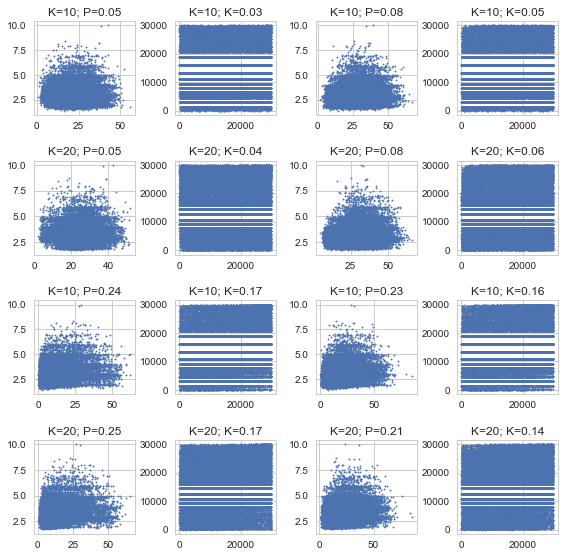

In [258]:
fig, ax = plt.subplots(4,4)
fig.tight_layout(pad=1)
fig.set_figwidth(8)
fig.set_figheight(8)

plot_tsne_corr("../disser_plots/experiment_3_2/inference/simple_ae/embeddings.npz", ax, 0, 0)
plot_tsne_corr("../disser_plots/experiment_3_2/inference/siam_inference_classic_siam/embeddings.npz", ax, 0, 2)
plot_tsne_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_lev/embeddings.npz", ax, 2, 0)
plot_tsne_corr("../disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_loglev/embeddings.npz", ax, 2, 2)

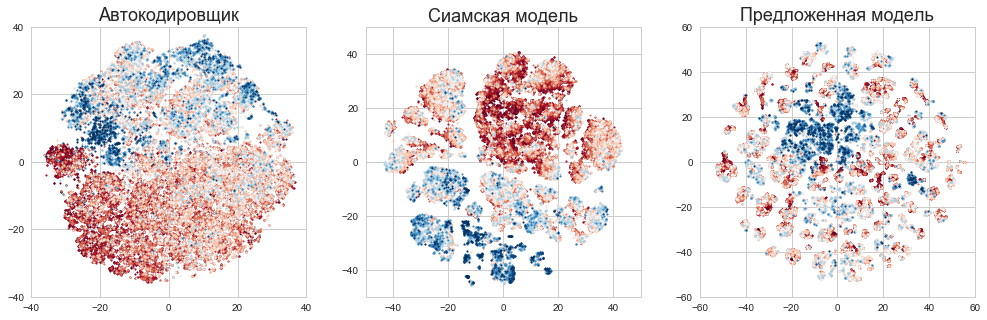

In [327]:
fig, ax = plt.subplots(1, 3)
fig.tight_layout(pad=.1)
fig.subplots_adjust(top=.9, bottom=.15)
fig.set_figwidth(14)
fig.set_figheight(5)

plot_tsne("simple_ae", ax[0], alpha=1)
ax[0].set_title("Автокодировщик")
ax[0].title.set_fontsize(18)
ax[0].set_xlim((-40, 40))
ax[0].set_ylim((-40, 40))
ax[0].set_xticks(np.arange(-40, 41, 20))
ax[0].set_yticks(np.arange(-40, 41, 20))

plot_tsne("siam_inference_classic_siam", ax[1], alpha=1)
ax[1].set_title("Сиамская модель")
ax[1].title.set_fontsize(18)
ax[1].set_xlim((-50, 50))
ax[1].set_ylim((-50, 50))

plot_tsne("siam_inference_ae_lat30_hid32_mse_loglev", ax[2], alpha=1)
ax[2].set_title("Предложенная модель")
ax[2].title.set_fontsize(18)
ax[2].set_xlim((-60, 60))
ax[2].set_ylim((-60, 60))

fig.savefig("experiment_3_2/exp_3_2_compare.png")

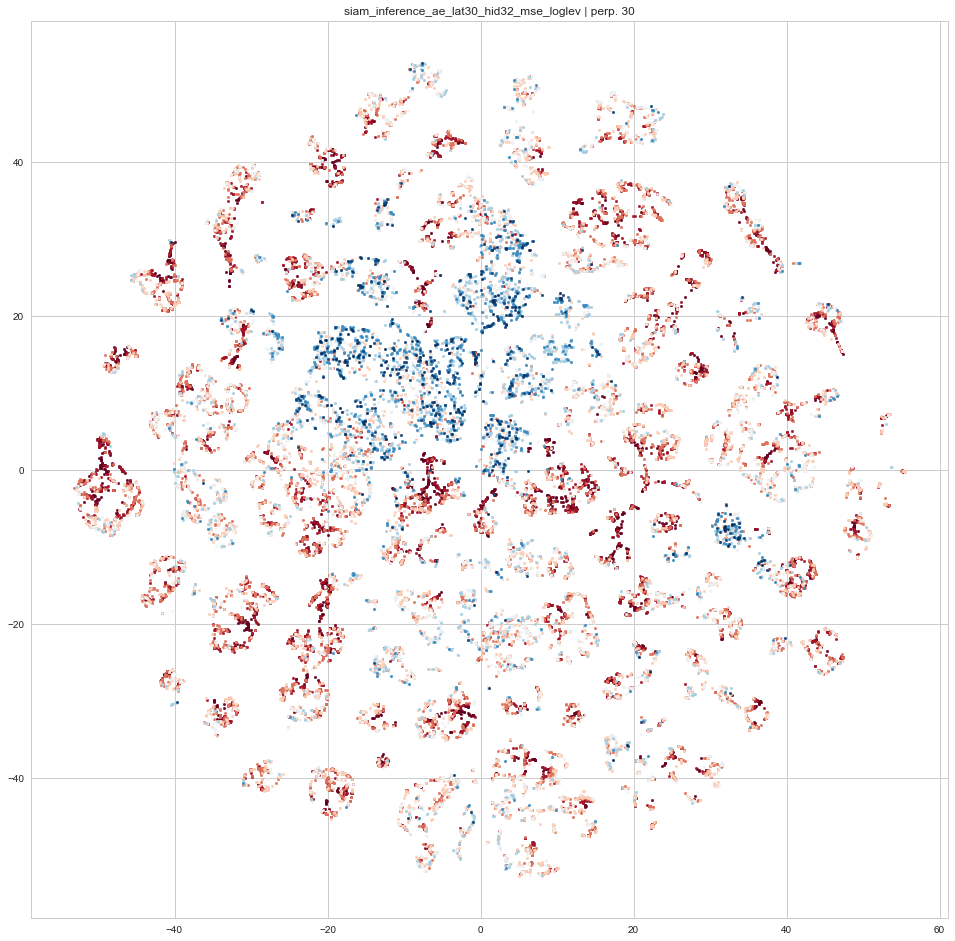

In [315]:
fig, ax = plt.subplots(1, 1)
fig.tight_layout(pad=1)
fig.set_figwidth(14)
fig.set_figheight(14)

plot_tsne("siam_inference_ae_lat30_hid32_mse_loglev", ax, 7, alpha=1)

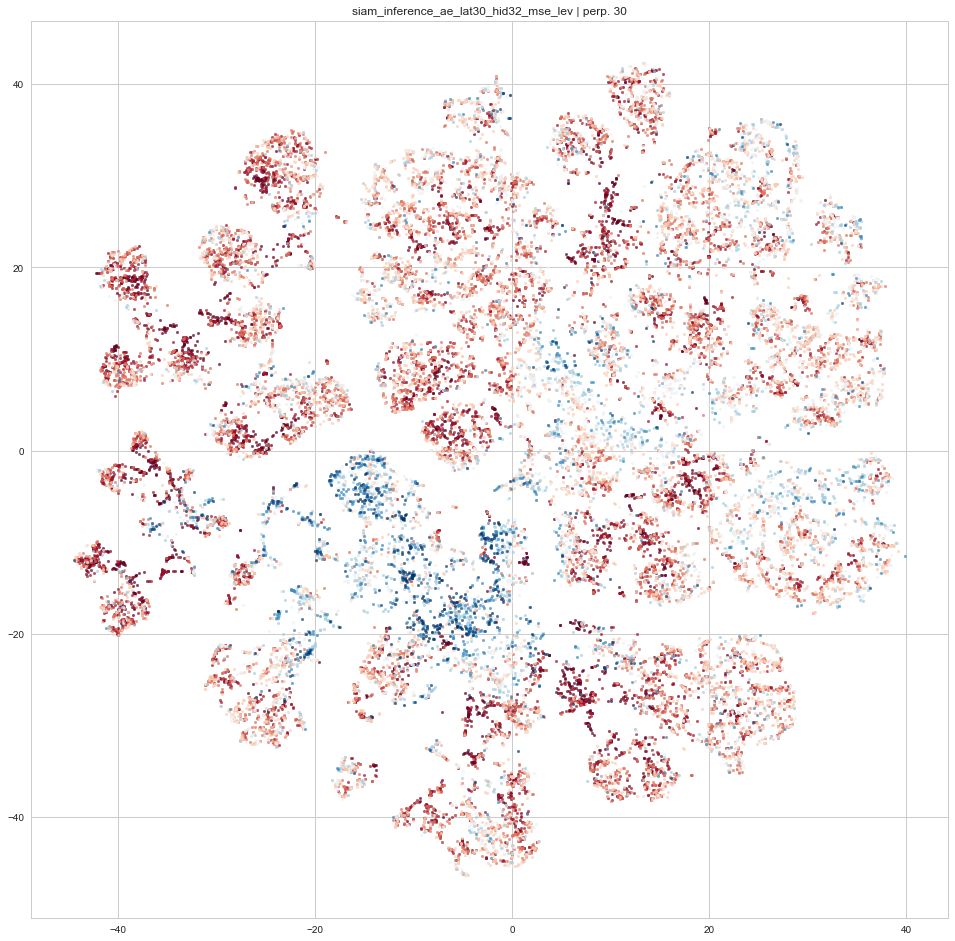

In [314]:
fig, ax = plt.subplots(1, 1)
fig.tight_layout(pad=1)
fig.set_figwidth(14)
fig.set_figheight(14)

plot_tsne("siam_inference_ae_lat30_hid32_mse_lev", ax, 7, alpha=.75)